In [ ]:
# ===========================
# Hybrid Ensemble for Accident Prediction
# ===========================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# ---------------------------
# Load Dataset
# ---------------------------
df = pd.read_csv("/content/upsampled_dataset_1200_records.csv")

target_col = "Accident"
X = df.drop(columns=[target_col]).values
y = df[target_col].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# Torch Dataset
# ---------------------------
class AccidentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(AccidentDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader   = DataLoader(AccidentDataset(X_val, y_val), batch_size=128, shuffle=False)

# ---------------------------
# FT-Transformer
# ---------------------------
class FeatureTokenizer(nn.Module):
    def __init__(self, n_features, d_model, dropout=0.3):
        super().__init__()
        self.num_proj = nn.Parameter(torch.empty(n_features, d_model))
        nn.init.xavier_uniform_(self.num_proj)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        tokens = torch.einsum("bf,fd->bfd", x, self.num_proj)
        cls = self.cls_token.expand(x.size(0), -1, -1)
        return self.dropout(torch.cat([cls, tokens], dim=1))

class FTTransformer(nn.Module):
    def __init__(self, n_features, d_model=256, nhead=16, ff_dim=128,
                 num_layers=3, dropout=0.3, out_dim=1):
        super().__init__()
        self.tok = FeatureTokenizer(n_features, d_model, dropout)
        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, out_dim)

    def forward(self, x):
        x = self.tok(x)
        x = self.encoder(x)
        cls = self.norm(x[:, 0, :])
        return self.head(cls).squeeze(1)

# ---------------------------
# Train FT-Transformer
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
ft_model = FTTransformer(n_features=X.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(ft_model.parameters(), lr=1e-3, weight_decay=1e-4)

def train_epoch(loader, train=True):
    ft_model.train(train)
    total_loss, preds, labels = 0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train: optimizer.zero_grad()
        logits = ft_model(xb)
        loss = criterion(logits, yb)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
            optimizer.step()
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds.extend(probs)
        labels.extend(yb.cpu().numpy())
        total_loss += loss.item() * yb.size(0)
    return total_loss/len(loader.dataset), np.array(preds), np.array(labels)

for epoch in range(50):  # keep epochs small for speed
    tr_loss, _, _ = train_epoch(train_loader, True)
    va_loss, _, _ = train_epoch(val_loader, False)
    print(f"Epoch {epoch+1:02d} | Train Loss {tr_loss:.4f} | Val Loss {va_loss:.4f}")

# Get final predictions
_, ft_train_preds, _ = train_epoch(train_loader, False)
_, ft_val_preds, _   = train_epoch(val_loader, False)

# ---------------------------
# Traditional ML Models
# ---------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_train_preds = rf.predict_proba(X_train)[:,1]
rf_val_preds   = rf.predict_proba(X_val)[:,1]

xgb = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train, y_train)
xgb_train_preds = xgb.predict_proba(X_train)[:,1]
xgb_val_preds   = xgb.predict_proba(X_val)[:,1]

# ---------------------------
# Stacking (Meta-Ensemble)
# ---------------------------
train_meta = np.vstack([ft_train_preds, rf_train_preds, xgb_train_preds]).T
val_meta   = np.vstack([ft_val_preds, rf_val_preds, xgb_val_preds]).T

meta = LogisticRegression()
meta.fit(train_meta, y_train)
final_preds = meta.predict(val_meta)

# ---------------------------
# Evaluation
# ---------------------------
acc = accuracy_score(y_val, final_preds)
f1  = f1_score(y_val, final_preds)

print("\nHybrid Ensemble Performance:")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Epoch 01 | Train Loss 0.7939 | Val Loss 0.6938
Epoch 02 | Train Loss 0.7023 | Val Loss 0.7282
Epoch 03 | Train Loss 0.6935 | Val Loss 0.7066
Epoch 04 | Train Loss 0.6963 | Val Loss 0.7654
Epoch 05 | Train Loss 0.7054 | Val Loss 0.6632
Epoch 06 | Train Loss 0.6803 | Val Loss 0.6846
Epoch 07 | Train Loss 0.6500 | Val Loss 0.6389
Epoch 08 | Train Loss 0.6310 | Val Loss 0.6420
Epoch 09 | Train Loss 0.6033 | Val Loss 0.6415
Epoch 10 | Train Loss 0.6059 | Val Loss 0.6707
Epoch 11 | Train Loss 0.5654 | Val Loss 0.6508
Epoch 12 | Train Loss 0.5558 | Val Loss 0.6176
Epoch 13 | Train Loss 0.5588 | Val Loss 0.6613
Epoch 14 | Train Loss 0.5078 | Val Loss 0.6379
Epoch 15 | Train Loss 0.5214 | Val Loss 0.6978
Epoch 16 | Train Loss 0.4845 | Val Loss 0.6615
Epoch 17 | Train Loss 0.4734 | Val Loss 0.7586
Epoch 18 | Train Loss 0.4693 | Val Loss 0.6392
Epoch 19 | Train Loss 0.4268 | Val Loss 0.7349
Epoch 20 | Train Loss 0.4073 | Val Loss 0.7917
Epoch 21 | Train Loss 0.4184 | Val Loss 0.7270
Epoch 22 | Tr

In [ ]:
!pip install lime
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1699791898787599a958cb4d6484532c620d78b01183966ffe5fe0124736a6ec
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime



=== SHAP Interpretation (XGBoost) ===


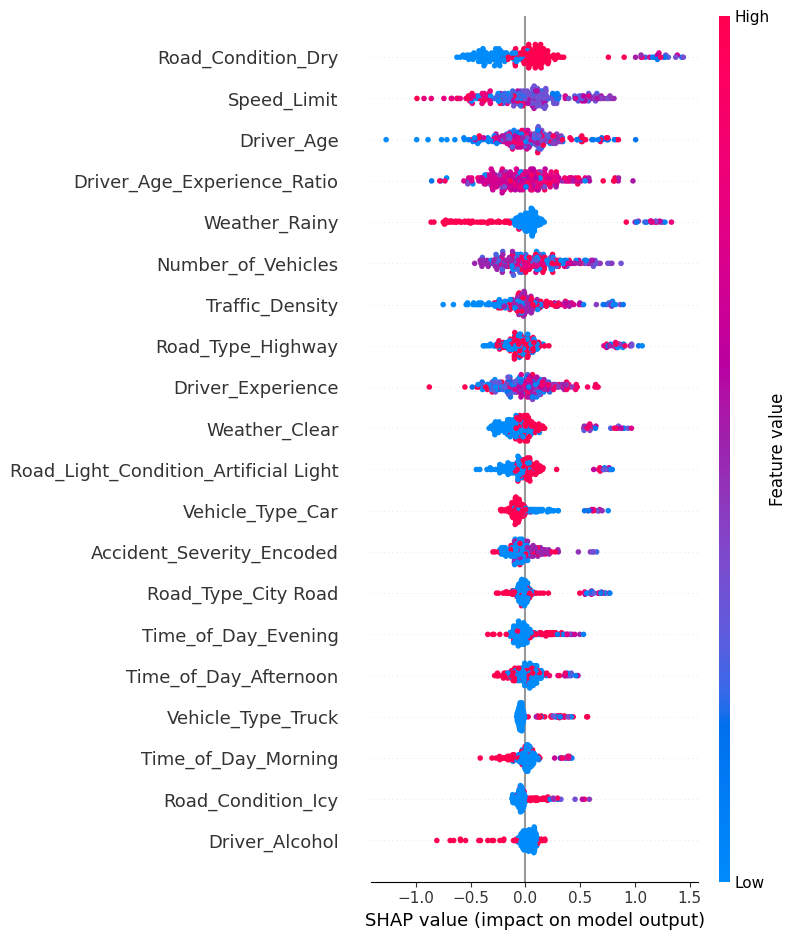


=== SHAP Interpretation (RandomForest) ===


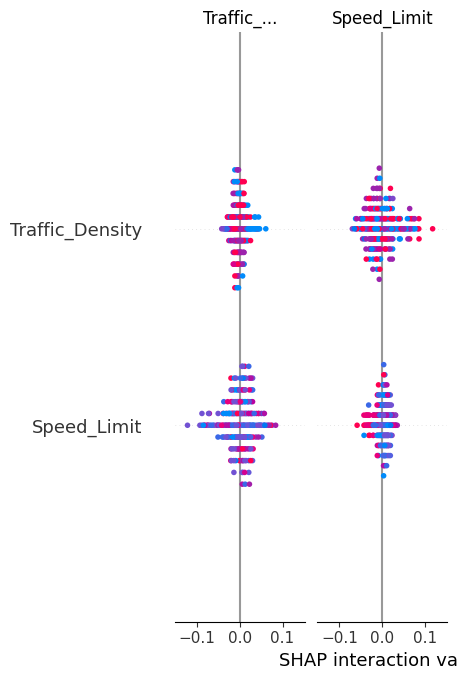

<Figure size 640x480 with 0 Axes>


=== Meta-Classifier (Logistic Regression) Weights ===


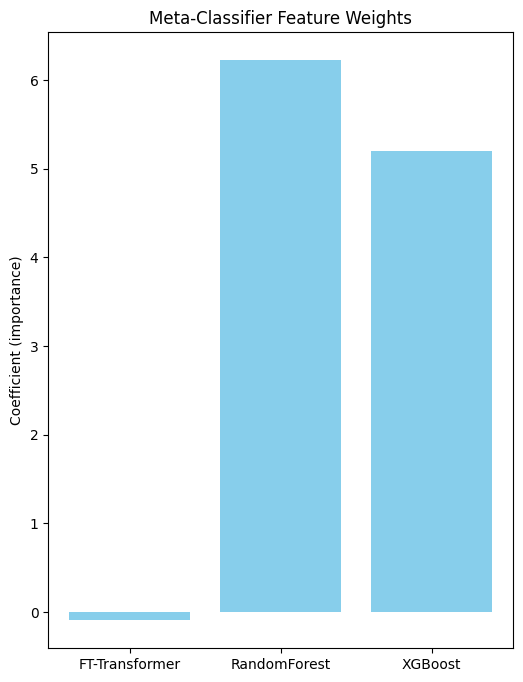


=== LIME Local Explanation ===

LIME Explanation for Validation Instance 23:


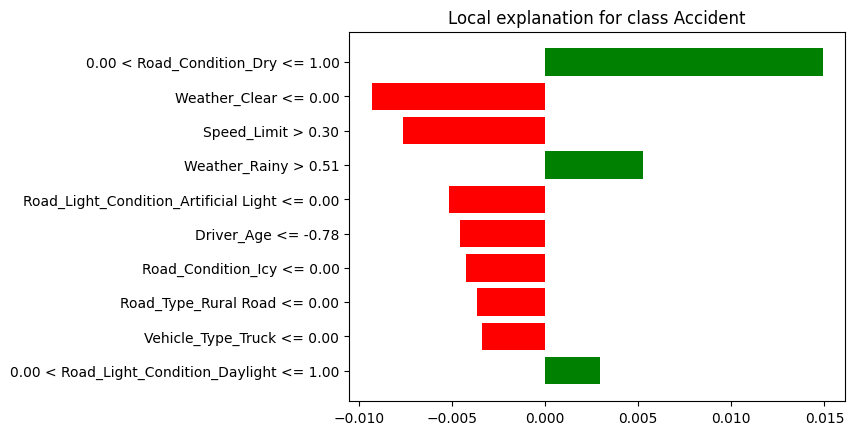

In [ ]:
# ===========================
# Explainable AI (XAI) - Tree SHAP + LIME for FT-Transformer
# ===========================
import shap
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import torch
import torch.nn as nn

feature_names = df.drop(columns=[target_col]).columns

# ---------------------------
# Utility: Handle SHAP values safely
# ---------------------------
def get_shap_values(shap_values):
    if isinstance(shap_values, list):
        if len(shap_values) > 1:
            return shap_values[1]   # positive class
        else:
            return shap_values[0]
    return shap_values

# ---------------------------
# SHAP for XGBoost
# ---------------------------
print("\n=== SHAP Interpretation (XGBoost) ===")
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = get_shap_values(explainer_xgb.shap_values(X_val))
shap.summary_plot(shap_values_xgb, X_val, feature_names=feature_names)

# ---------------------------
# SHAP for RandomForest
# ---------------------------
import matplotlib.pyplot as plt
import shap

print("\n=== SHAP Interpretation (RandomForest) ===")
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = get_shap_values(explainer_rf.shap_values(X_val))

# Don't auto-show yet
shap.summary_plot(
    shap_values_rf,
    X_val,
    feature_names=feature_names,
    show=True,          # <- important
    plot_size=(10, 10)     # width, height in inches; tweak as needed
)

# Adjust the figure that SHAP just created
plt.tight_layout()       # reduces clipping
plt.show()


# ---------------------------
# Meta-Classifier Weights
# ---------------------------
print("\n=== Meta-Classifier (Logistic Regression) Weights ===")
meta_features = ["FT-Transformer", "RandomForest", "XGBoost"]
coef = meta.coef_[0]

plt.figure(figsize=(6,8))
plt.bar(meta_features, coef, color="skyblue")
plt.title("Meta-Classifier Feature Weights")
plt.ylabel("Coefficient (importance)")
plt.show()

# ---------------------------
# LIME for Local Interpretability (FT-Transformer)
# ---------------------------
print("\n=== LIME Local Explanation ===")

def meta_predict_fn(data):
    ft_preds = torch.sigmoid(ft_model(torch.tensor(data, dtype=torch.float32).to(device))).detach().cpu().numpy()
    rf_preds = rf.predict_proba(data)[:,1]
    xgb_preds = xgb.predict_proba(data)[:,1]
    stacked = np.vstack([ft_preds, rf_preds, xgb_preds]).T
    return meta.predict_proba(stacked)

lime_explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=["No Accident", "Accident"],
    mode="classification"
)

idx = np.random.randint(0, X_val.shape[0])
exp = lime_explainer.explain_instance(X_val[idx], meta_predict_fn, num_features=10)

print(f"\nLIME Explanation for Validation Instance {idx}:")
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.show()


In [ ]:
 from sklearn.linear_model import LogisticRegression

# ===========================
# Baseline 1: RF + XGB
# ===========================

# Get predictions (probabilities) from RF and XGB
rf_train_preds = rf.predict_proba(X_train)[:, 1]
xgb_train_preds = xgb.predict_proba(X_train)[:, 1]
rf_val_preds = rf.predict_proba(X_val)[:, 1]
xgb_val_preds = xgb.predict_proba(X_val)[:, 1]

# Stack them (2 features: RF, XGB)
stacked_train_baseline1 = np.vstack([rf_train_preds, xgb_train_preds]).T
stacked_val_baseline1 = np.vstack([rf_val_preds, xgb_val_preds]).T

# Meta-classifier (logistic regression)
meta_rf_xgb = LogisticRegression(max_iter=500, solver="lbfgs")
meta_rf_xgb.fit(stacked_train_baseline1, y_train)

# Validation accuracy
baseline1_acc = meta_rf_xgb.score(stacked_val_baseline1, y_val)
print(f"Baseline 1 (RF + XGB only) Validation Accuracy: {baseline1_acc:.4f}")


Baseline 1 (RF + XGB only) Validation Accuracy: 0.7917


In [ ]:
from sklearn.metrics import accuracy_score

# ===========================
# Baseline 2: FT-Transformer Only
# ===========================

ft_model.eval()
with torch.no_grad():
    ft_train_preds = torch.sigmoid(ft_model(torch.tensor(X_train, dtype=torch.float32).to(device))).cpu().numpy().flatten()
    ft_val_preds = torch.sigmoid(ft_model(torch.tensor(X_val, dtype=torch.float32).to(device))).cpu().numpy().flatten()

# Convert probabilities to binary predictions
ft_val_labels = (ft_val_preds > 0.5).astype(int)

# Accuracy
baseline2_acc = accuracy_score(y_val, ft_val_labels)
print(f"Baseline 2 (FT-Transformer only) Validation Accuracy: {baseline2_acc:.4f}")


Baseline 2 (FT-Transformer only) Validation Accuracy: 0.7042
